In [2]:
from tqdm import tqdm
import time
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import time
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset,DataLoader

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cpu


In [11]:
# Dictionary storing network parameters.
params = {
    'batch_size': 128,# Batch size.
    'num_epochs': 5,# Number of epochs to train for.
    'learning_rate': 2e-4,# Learning rate.
    'beta1': 0.5,
    'beta2': 0.999,
    'save_epoch' : 50,# After how many epochs to save checkpoints and generate test output.
    'dataset' : 'MNIST'} # Dataset to use. Choose from {MNIST, SVHN, CelebA, FashionMNIST}. CASE MUST MATCH EXACTLY!!!!!

In [12]:
# Directory containing the data.
root = 'data/'

def get_data(dataset, batch_size):

    # Get MNIST dataset.
    if dataset == 'MNIST':
        transform = transforms.Compose([
            transforms.Resize(28),
            transforms.CenterCrop(28),
            transforms.ToTensor()])

        dataset = dsets.MNIST(root+'mnist/', train='train',
                                download=True, transform=transform)


    # Get FashionMNIST dataset.
    elif dataset == 'FashionMNIST':
        transform = transforms.Compose([
            transforms.Resize(28),
            transforms.CenterCrop(28),
            transforms.ToTensor()])

        dataset = dsets.FashionMNIST(root+'fashionmnist/', train='train',
                                download=True, transform=transform)

    # Get CelebA dataset.

    # Create dataloader.
    dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

    return dataloader

dataloader = get_data(params['dataset'], params['batch_size'])

In [13]:
# Generator
class Generator(nn.Module):
  """
  The Generator takes a noise vector concatenated with latent codes and generates an image.

  Args:
      tconv1 (nn.ConvTranspose2d): Deconvolution layer to project input noise to a high-dimensional space.
      bn1 (nn.BatchNorm2d): Batch normalization layer to stabilize training.
      tconv2 (nn.ConvTranspose2d): Deconvolution layer to increase spatial resolution.
      bn2 (nn.BatchNorm2d): Batch normalization layer to normalize features.
      tconv3 (nn.ConvTranspose2d): Deconvolution layer for further upsampling.
      bn3 (nn.BatchNorm2d): Batch normalization layer to stabilize training.
      tconv4 (nn.ConvTranspose2d): Final deconvolution layer to produce a 1-channel output image.

  Returns:
      img (torch.Tensor): A generated image with dimensions [batch_size, 1, 28, 28].

  Example:
      generator = Generator()
      noise = torch.randn(batch_size, latent_dim, 1, 1)  # Random noise input
      generated_img = generator(noise)  # Generate image
  """
  def __init__(self):
    super().__init__()

    self.tconv1 = nn.ConvTranspose2d(74, 1024, 1, 1, bias=False)
    self.bn1 = nn.BatchNorm2d(1024)

    self.tconv2 = nn.ConvTranspose2d(1024, 128, 7, 1, bias=False)
    self.bn2 = nn.BatchNorm2d(128)

    self.tconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)
    self.bn3 = nn.BatchNorm2d(64)

    self.tconv4 = nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False)

  def forward(self, x):
    x = F.relu(self.bn1(self.tconv1(x)))
    x = F.relu(self.bn2(self.tconv2(x)))
    x = F.relu(self.bn3(self.tconv3(x)))

    img = torch.sigmoid(self.tconv4(x))

    return img

In [14]:
# Discriminator
class Discriminator(nn.Module):
  """
  The Discriminator takes an image as input and outputs a feature map.

  Args:
      conv1 (nn.Conv2d): Convolution layer to extract low-level features.
      conv2 (nn.Conv2d): Convolution layer to extract mid-level features.
      bn2 (nn.BatchNorm2d): Batch normalization layer to stabilize training.
      conv3 (nn.Conv2d): Convolution layer to extract high-level features.
      bn3 (nn.BatchNorm2d): Batch normalization layer to normalize features.

  Returns:
      x (torch.Tensor): A high-dimensional feature map for further processing.

  Example:
      discriminator = Discriminator()
      feature_map = discriminator(input_image)  # Extract feature map
  """
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

    self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
    self.bn2 = nn.BatchNorm2d(128)

    self.conv3 = nn.Conv2d(128, 1024, 7, bias=False)
    self.bn3 = nn.BatchNorm2d(1024)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
    x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
    x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)

    return x

In [15]:
class DHead(nn.Module):
  """
  The DHead outputs the probability that the input image is real or fake.

  Args:
      conv (nn.Conv2d): Convolution layer to map the feature map to a single scalar value.

  Returns:
      output (torch.Tensor): Probability indicating real (1) or fake (0) for each input.

  Example:
      dhead = DHead()
      real_or_fake = dhead(feature_map)  # Predict real/fake probability
  """
  def __init__(self):
    super().__init__()

    self.conv = nn.Conv2d(1024, 1, 1)

  def forward(self, x):
    output = torch.sigmoid(self.conv(x))

    return output

class QHead(nn.Module):
  """
  The QHead predicts latent code information (discrete and continuous) from the Discriminator's feature map.

  Args:
      conv1 (nn.Conv2d): Convolution layer to reduce feature dimensions.
      bn1 (nn.BatchNorm2d): Batch normalization layer to stabilize training.
      conv_disc (nn.Conv2d): Convolution layer to predict discrete latent codes.
      conv_mu (nn.Conv2d): Convolution layer to predict mean of continuous latent codes.
      conv_var (nn.Conv2d): Convolution layer to predict variance of continuous latent codes.

  Returns:
      disc_logits (torch.Tensor): Predicted logits for discrete latent codes.
      mu (torch.Tensor): Predicted mean for continuous latent codes.
      var (torch.Tensor): Predicted variance for continuous latent codes.

  Example:
      qhead = QHead() # 분류형 잠재 변수의 Cross-Entropy Loss + 연속형 잠재 변수의 Negative Log-Likelihood
      disc_logits, mu, var = qhead(feature_map)  # Predict latent codes
  """

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1024, 128, 1, bias=False)
    self.bn1 = nn.BatchNorm2d(128)

    self.conv_disc = nn.Conv2d(128, 10, 1)
    self.conv_mu = nn.Conv2d(128, 2, 1)
    self.conv_var = nn.Conv2d(128, 2, 1)

  def forward(self, x):
    x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

    disc_logits = self.conv_disc(x).squeeze()

    mu = self.conv_mu(x).squeeze()
    var = torch.exp(self.conv_var(x).squeeze())

    return disc_logits, mu, var

In [16]:
# Weight, Noise, Loss Function

def weights_inits(m):
  """
  Initialize weights of the model.
  """

  if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d): # 평균 = 0, 표준 편차 = 0.02
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif(type(m) == nn.BatchNorm2d): # 평균 = 1, 표준 편차 = 0.02, bias = 0
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

class NormalNLLLoss:
  """
  The NormalNLLLoss computes the negative log-likelihood of the predicted continuous latent codes.

  Args:
      x (torch.Tensor): Ground-truth latent codes.
      mu (torch.Tensor): Predicted mean of latent codes from QHead.
      var (torch.Tensor): Predicted variance of latent codes from QHead.

  Returns:
      nll (torch.Tensor): Negative log-likelihood loss to be minimized. # 입력된 mu(예측 평균)과 var(예측 분산)로부터 실제 값 x와의 차이를 기반으로 손실을 계산

  Example:
      nll_loss = NormalNLLLoss()
      loss = nll_loss(latent_code, predicted_mu, predicted_var)  # Compute NLL loss
  """

  def __call__(self, x, mu, var):
    logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
    nll = -(logli.sum(1).mean())

    return nll

def noise_sample(num_d, dim_d, num_c, n_z, batch_size, device):
  """
  Args:
      z (torch.Tensor): General Gaussian Noise.
      num_d (int): The number of discrete latent codes.
      dim_d (int): The dimension of each discrete latent code (e.g., number of categories for a latent variable).
      num_c (int): The number of continuous latent codes.
      n_z (int): The dimension of incompressible random noise (standard Gaussian noise).
      batch_size (int): The number of samples in each batch.
      device (str or torch.device): Specifies whether to use GPU or CPU for computations.

  Returns:
      noise (torch.Tensor): A concatenated noise tensor combining random noise, discrete latent codes,
                            and continuous latent codes, with dimensions [batch_size, total_dim, 1, 1].
      idx (np.ndarray): A NumPy array storing the indices of sampled categories for discrete latent codes.

  Results:
      - Random noise for general variability.
      - Discrete latent codes for categorical control (digit class).
      - Continuous latent codes for fine-grained control (rotation, thickness)
  """

  z = torch.randn(batch_size, n_z, 1, 1, device=device)

  idx = np.zeros((num_d, batch_size))
  if(num_d != 0):
    dis_c = torch.zeros(batch_size, num_d, dim_d, device=device)

    for i in range(num_d):
      idx[i] = np.random.randint(dim_d, size=batch_size)
      dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

    dis_c = dis_c.view(batch_size, -1, 1, 1)

  if(num_c != 0):
    # Random uniform between -1 and 1.
    con_c = (torch.rand(batch_size, num_c, 1, 1, device=device) * 2 - 1)

  noise = z
  if(num_d != 0):
    noise = torch.cat((z, dis_c), dim=1)
  if(num_c != 0):
    noise = torch.cat((noise, con_c), dim=1)

  return noise, idx

Generator(
  (tconv1): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 1024, kernel_size=(7, 7), stride=(1, 1), bias=False)
 

400it [35:21,  5.22s/it]

[1/5][400/469]	Loss_D: 0.2811	Loss_G: 2.6796


469it [41:17,  5.28s/it]
400it [30:50,  5.02s/it]

[2/5][400/469]	Loss_D: 0.5784	Loss_G: 2.0605


469it [36:20,  4.65s/it]
400it [32:07,  4.69s/it]

[3/5][400/469]	Loss_D: 0.8693	Loss_G: 1.6894


469it [37:20,  4.78s/it]
400it [29:48,  4.54s/it]

[4/5][400/469]	Loss_D: 0.9247	Loss_G: 1.4318


469it [34:55,  4.47s/it]
400it [30:01,  4.61s/it]

[5/5][400/469]	Loss_D: 0.8754	Loss_G: 1.3854


469it [35:19,  4.52s/it]


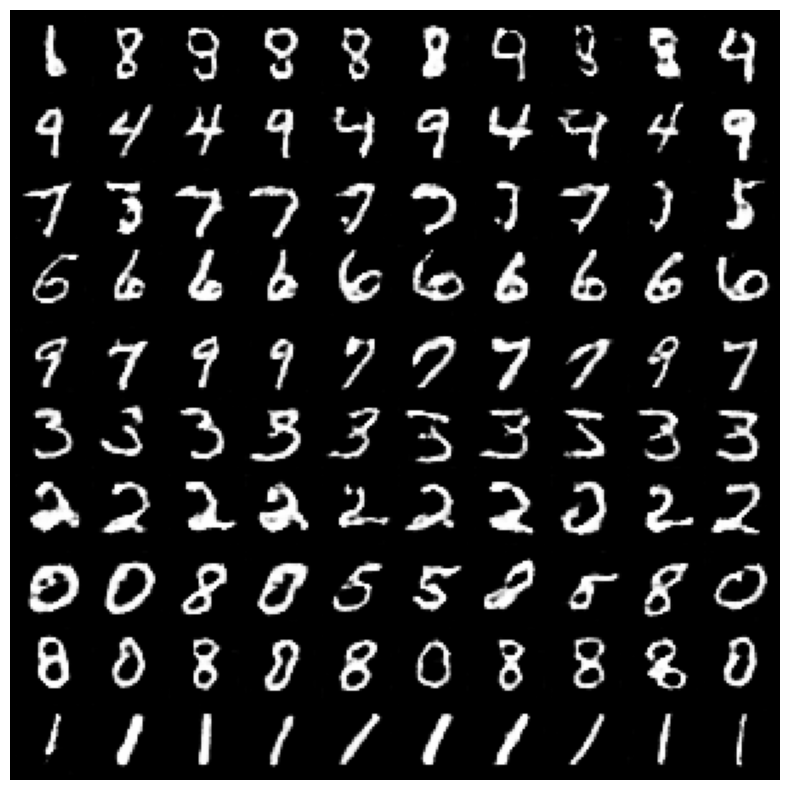

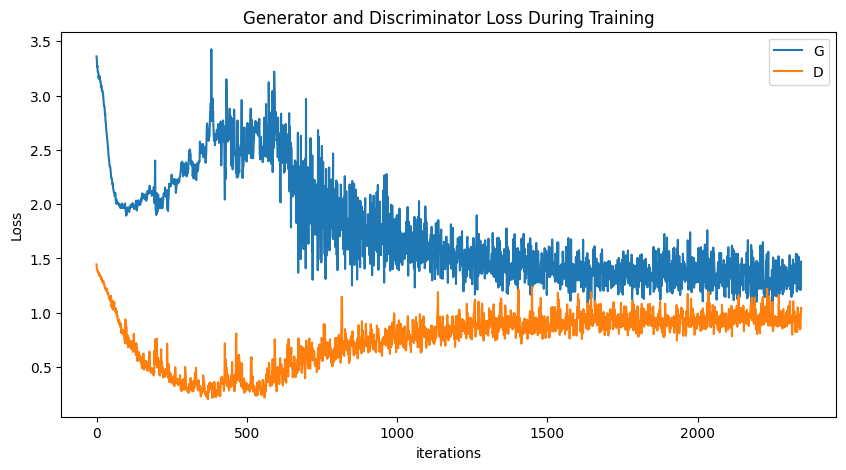

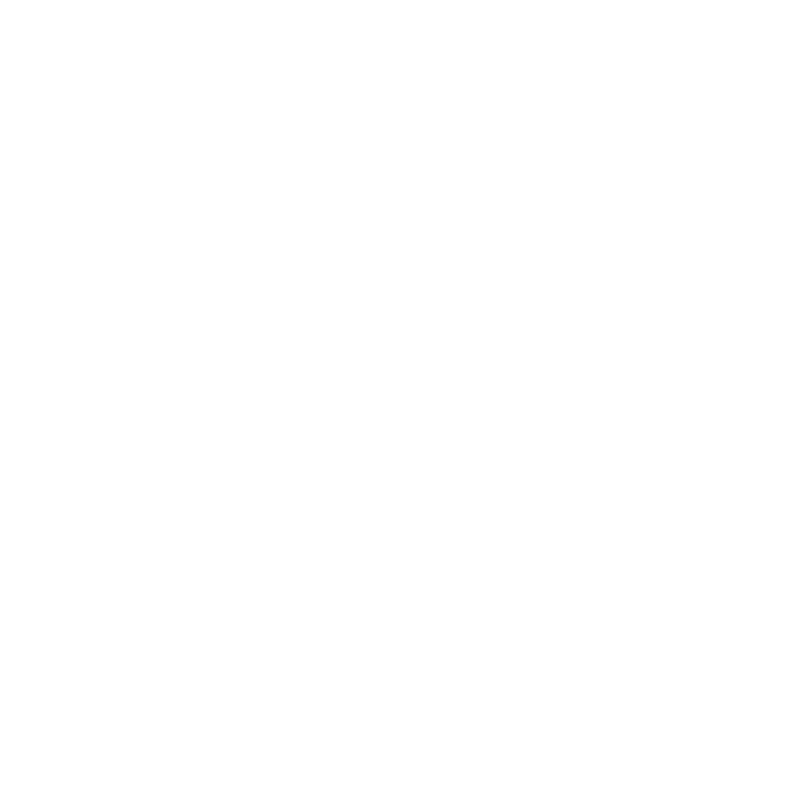

In [17]:
# Set appropriate hyperparameters depending on the dataset used.
# The values given in the InfoGAN paper are used.

"""
Args:
    params (dict): Dictionary of hyperparameter
    - params['dataset']: Name of dataset.
    - params['num_z']: Latent of Generator input noise vector z.
    - params['num_dc']: Number of Discrete latent code.
    - params['dim_dc']: Number of class which is available in every latent of discrete latent code.
    - params['num_cc']: Number of continuous latent code.
    - params['learning_rate']: Learning rate of Adam Optimizer
    - params['beta1'], params['beta2']: Momentum rate of Adam Optimizer
    dataloader (torch.utils.data.DataLoader): Load dataset and provide batch
    device (torch.device): Device which progress model and tensor
"""

if(params['dataset'] == 'MNIST'):
  params['num_z'] = 62
  params['num_dc'] = 1
  params['dim_dc'] = 10
  params['num_cc'] = 2

elif(params['dataset'] == 'FashionMNIST'):
  params['num_z'] = 62
  params['num_dc'] = 1
  params['dim_dc'] = 10
  params['num_con_c'] = 2

# Plot the training images
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 100], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.savefig('Training Images {}'.format(params['dataset']))
plt.close('all')

# Initialize the Network
netG = Generator().to(device)
netG.apply(weights_inits)
print(netG)

discriminator = Discriminator().to(device)
discriminator.apply(weights_inits)
print(discriminator)

netD = DHead().to(device)
netD.apply(weights_inits)
print(netD)

netQ = QHead().to(device)
netQ.apply(weights_inits)
print(netQ)

# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
"""
Binary Cross-Entropy Loss trains discriminator to discriminate real and fake image.

Args:
    input (torch.Tensor): Discriminator output
    target (torch.Tensor): label(1: real, 0: fake)

Returns:
    loss (torch.Tensor): Loss of Discriminator

Example:
    loss_d = criterionD(output_real, real_labels) + criterionD(output_fake, fake_labels)
"""
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
"""
CrossEntropyLoss trains QHead to predict discrete latent code's precise class.

Args:
    input (torch.Tensor): QHead output.
    target (torch.Tensor): Real class label.

Returns:
    loss (torch.Tensor): Discrete code loss value of QHead

Example:
    loss_q_dis = criterionQ_dis(predicted_logits, true_labels)
"""

# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

# Adam optimiser is used.
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))

# Fixed Noise
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z


if(params['num_dc'] != 0):
    idx = np.arange(params['dim_dc']).repeat(10)
    dis_c = torch.zeros(100, params['num_dc'], params['dim_dc'], device=device)
    for i in range(params['num_dc']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_cc'] != 0):
		# To find rotation and width
    con_c = (torch.rand(100, params['num_cc'], 1, 1, device=device) * 2 - 1)
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

"""
Descroption of key arguments (Args) used in the InfoGAN training code.

Args:
    params (dict): A dictionary of hyperparameter settings.
    - params['num_epochs']: Number of training epochs.
    - params['num_dc']: Number of discrete latent codes.
    - params['dim_dc']: Number of possible classes in each discrete latent code dimension.
    - params['num_cc']: Number of continuous latent codes.
    - params['num_z']: Dimensionality of the noise vector z for the generator.

    real_label (float): Label value used for real data.
    fake_label (float): Label value used for fake data.
    dataloader (torch.utils.data.DataLoader): A DataLoader object for loading the training dataset and batchs.
    device (torch.device): The device where models and tensors are executable

Result:
    - D_losses: A list of Discriminator loss values recorded during training.
    - G_losses: A list of Generator loss values recorded during training.
    - img_list: A list of images generated by the Generator using fixed noise during training.
"""

real_label = 1
fake_label = 0

img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(params['num_epochs']):
  for i, (data, _) in tqdm(enumerate(dataloader, 0)):
    # Get batch size
    b_size = data.size(0)
    # Transfer data tensor to GPU/CPU (device)
    real_data = data.to(device)

    # Updating discriminator and DHead
    optimD.zero_grad()
    # Real data
    label = torch.full((b_size, ), real_label, device=device)
    # label type을 맞추기 위해 추가
    label=label.to(torch.float32)
    output1 = discriminator(real_data)
    probs_real = netD(output1).view(-1)
    loss_real = criterionD(probs_real, label)
    # Calculate gradients.
    loss_real.backward()

    # Fake data
    label.fill_(fake_label)
    noise, idx = noise_sample(params['num_dc'], params['dim_dc'], params['num_cc'], params['num_z'], b_size, device)
    fake_data = netG(noise)
    output2 = discriminator(fake_data.detach())
    probs_fake = netD(output2).view(-1)
    loss_fake = criterionD(probs_fake, label)
    # Calculate gradients.
    loss_fake.backward()

    # Net Loss for the discriminator
    D_loss = loss_real + loss_fake
    # Update parameters
    optimD.step()

    # Updating Generator and QHead
    optimG.zero_grad()

    # Fake data treated as real.
    output = discriminator(fake_data)
    label.fill_(real_label)
    probs_fake = netD(output).view(-1)
    gen_loss = criterionD(probs_fake, label)

    q_logits, q_mu, q_var = netQ(output)
    target = torch.LongTensor(idx).to(device)
    # Calculating loss for discrete latent code.
    dis_loss = 0
    for j in range(params['num_dc']):
        dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

    # Calculating loss for continuous latent code.
    con_loss = 0
    if (params['num_cc'] != 0):
        con_loss = criterionQ_con(noise[:, params['num_z']+ params['num_dc']*params['dim_dc'] : ].view(-1, params['num_cc']), q_mu, q_var)*0.1

    # Net loss for generator.
    G_loss = gen_loss + dis_loss + con_loss
    # Calculate gradients.
    G_loss.backward()
    # Update parameters.
    optimG.step()

    # Check progress of training.
    if i != 0 and i%400 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
              % (epoch+1, params['num_epochs'], i, len(dataloader),
                D_loss.item(), G_loss.item()))

    # Save the losses for plotting.
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())

    iters += 1

    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) == params['num_epochs']/2) or epoch%5==0:
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_%d {}".format(params['dataset']) %(epoch+1))
        plt.close('all')


# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("Epoch_%d_{}".format(params['dataset']) %(params['num_epochs']))

# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss Curve {}".format(params['dataset']))

# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.show()